### Install Required Packages

In [1]:
! pip install torch torchvision numpy seaborn matplotlib

You should consider upgrading via the '/home/vangelis/.local/share/virtualenvs/machine-learning-msc-sNBHIkKd/bin/python -m pip install --upgrade pip' command.


### Imports

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 8)})
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset exploration

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images.shape: torch.Size([64, 3, 32, 32])


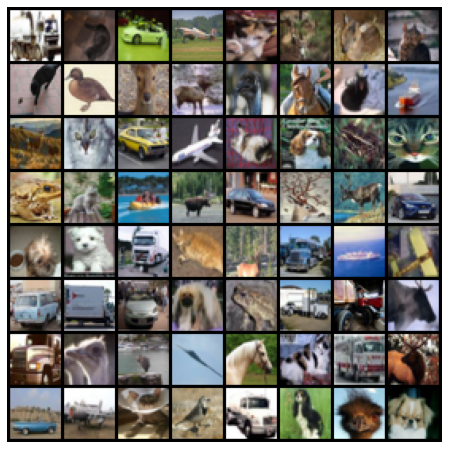

In [3]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
print(dataset.classes)

for images, _ in loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break
plt.show()

### Some insights extracted from the dataset exploration

The input of the Neural Network must be 3 * 32 * 32 (images shape) and the output must be equal to 10 (the number of classes).

### Split dataset into train and test set and apply normalizations

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define the batch size for the dataloaders
batch_size = 64

train_set = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### The Full Connected Neural Network Model

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_layer, second_layer, third_layer, out_layer):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=in_layer, out_features=second_layer),
            nn.ReLU(),
            nn.Linear(in_features=second_layer, out_features=second_layer),
            nn.ReLU(),
            nn.Linear(in_features=second_layer, out_features=third_layer),
            nn.ReLU(),
            nn.Linear(in_features=third_layer, out_features=out_layer),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Train and test loops in order to fit & predict data

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= size
    return train_loss

def test_loop(dataloader, model, loss_fn):
    """
    the test loop does not need the optimizer
    we just pass the data through the trained model and measure the error in predictions
    :param dataloader:
    :param model:
    :param loss_fn:
    :return:
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:
            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

### Methods that used to plot error and loss

In [7]:
def plot_losses(history, label):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Loss vs. No. of epochs {label} set')
    plt.show()


def plot_accuracies(history, label):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy vs. No. of epochs for {label} set')
    plt.show()

### Method that apply train/test loops for a given amount of epochs, learning rate & momentum

In [8]:
def train_nn(model, num_epochs, learning_rate, momentum=0):
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # define the optimizer object
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []

    print(f"Training for learning rate: {learning_rate}, momentum: {momentum}\n")
    for t in range(num_epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, accuracy = test_loop(test_dataloader, model, loss_fn)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(accuracy)

    plot_losses(train_loss_history, 'train')
    plot_losses(test_loss_history, 'test')
    plot_accuracies(test_accuracy_history, 'test')
    print(f'Accuracy after {num_epochs} epochs: {test_accuracy_history[num_epochs-1]}')
    print(f'Loss after {num_epochs} epochs: {test_loss_history[num_epochs-1]}')

## Training and optimizing Neural Network  3 * 32 * 32 -> 512 -> 256 ->10

#### Train and predict for learning_rate=0.001 for 40 epochs

The learning rate of 0.001 seems to yield very optimistic results, the curve of loss on each epoch converges to ~0.02 loss for both train and test.

Training for learning rate: 0.001, momentum: 0



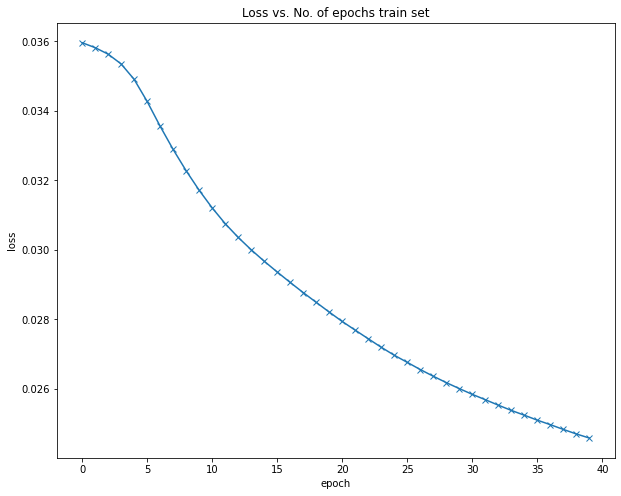

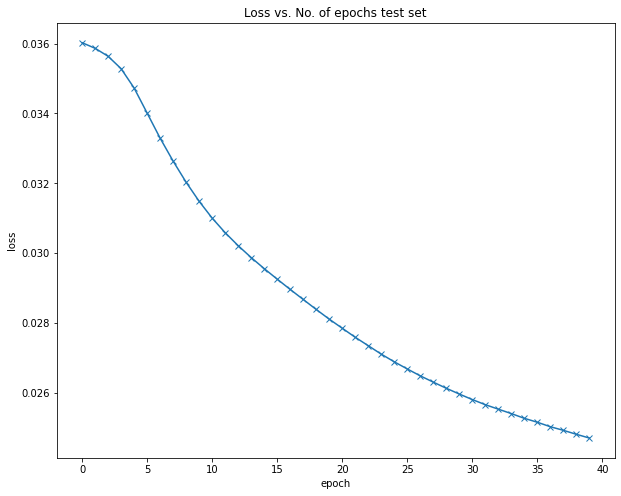

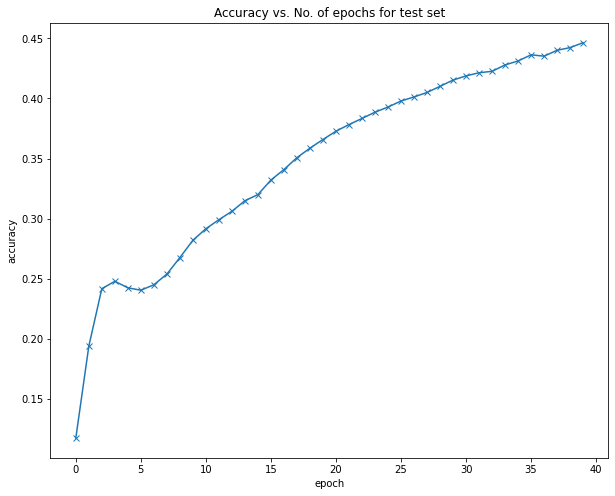

Accuracy after 40 epochs: 0.4464
Loss after 40 epochs: 0.02470093948841095


In [9]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=512, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.001, momentum=0)

### Train and predict for learning_rate=0.005 for 40 epochs

The learning rate of 0.005 seems to be also very good. The error rate for the train is dropped below 0.02 after 40 epochs, although for the test is encountered a minor increase after epoch 25, which may indicate a very slight overfit to our model. With less epochs (~20) this configuration could yield better results than the previous model (with 0.001 learning rate) in terms of accuracy and also training time (less epochs).

Training for learning rate: 0.005, momentum: 0



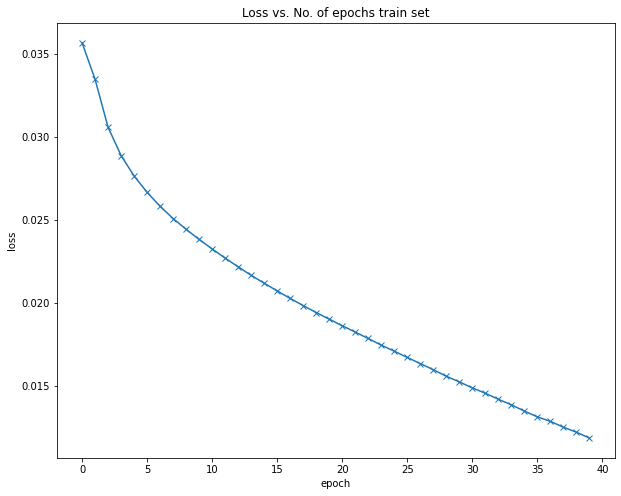

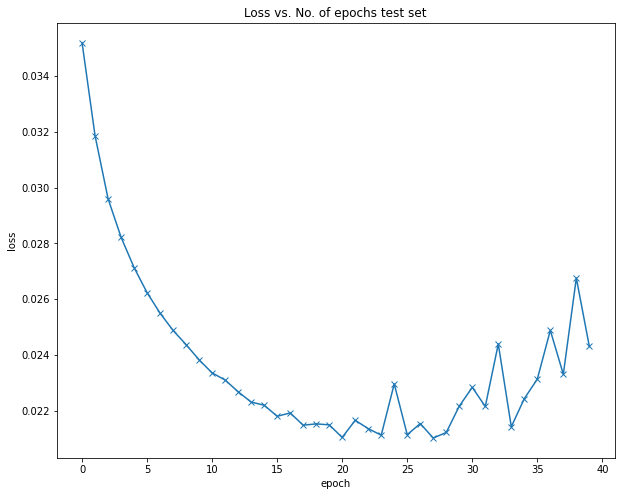

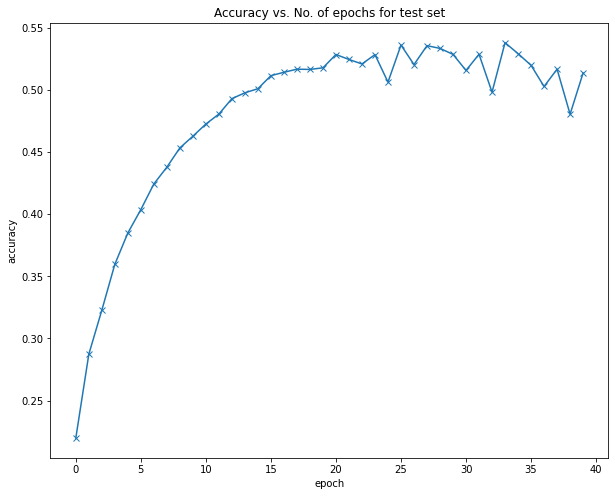

Accuracy after 40 epochs: 0.5134
Loss after 40 epochs: 0.024302379727363585


In [10]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=512, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.005, momentum=0)

### Train and predict for learning_rate=0.1 for 40 epochs

Here the things are starting to get pretty weird. First looking only the loss diagram for training set, it is noticed that after 25 epoch our model it is not learning anything new. Also at the same epoch the test loss gets increased (still pretty low though, under 0.1). Although, the accuracy after epoch 10 is not stabilized, it is increased and dropped constantly. So, we are safe to conclude that this model may be yield better accuracy after epoch 40 but it doesn't generalize well because of the instability of accuracy results.

Training for learning rate: 0.1, momentum: 0



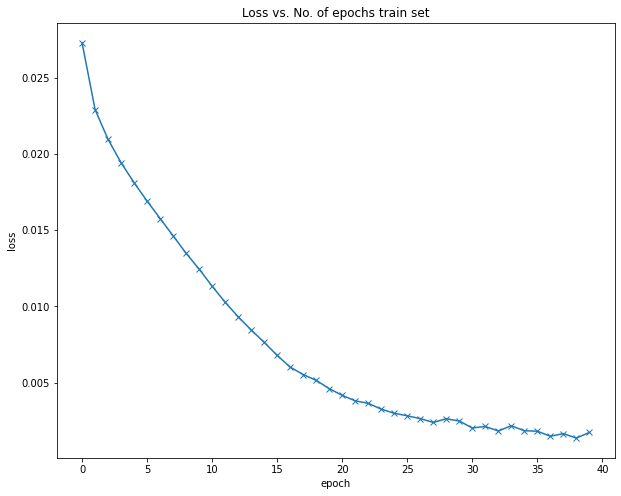

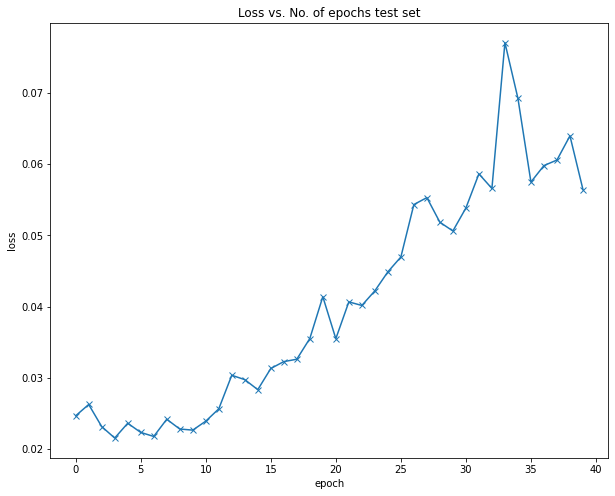

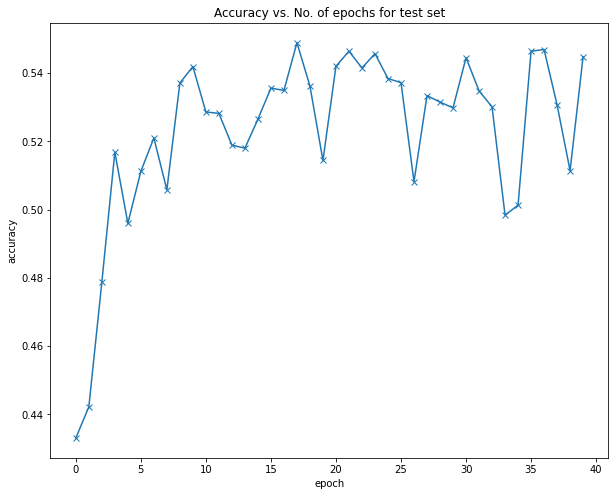

Accuracy after 40 epochs: 0.5448
Loss after 40 epochs: 0.056430298948287966


In [11]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=512, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.1, momentum=0)

## Using momentum

The below model configurations are using momentum in the optimizer. This will result to converge in earlier epoch, so the training phases below will use less number of epochs.

### Train and predict for learning_rate=0.005 & momentum=0.2 for 20 epochs

Training for learning rate: 0.005, momentum: 0.2



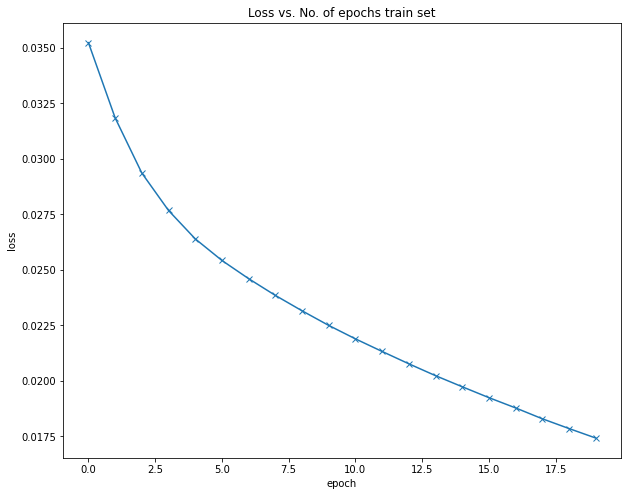

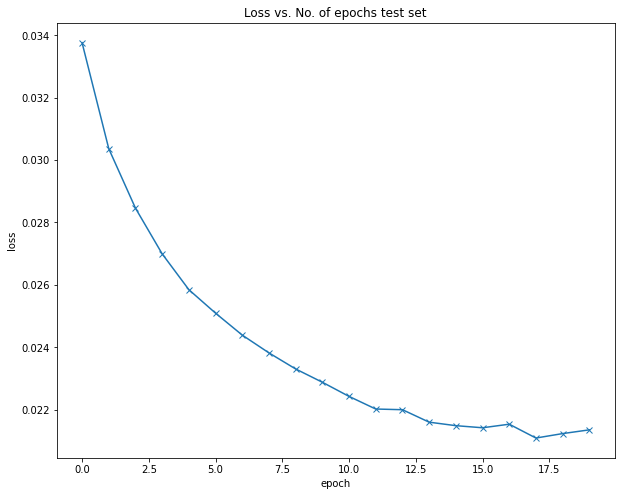

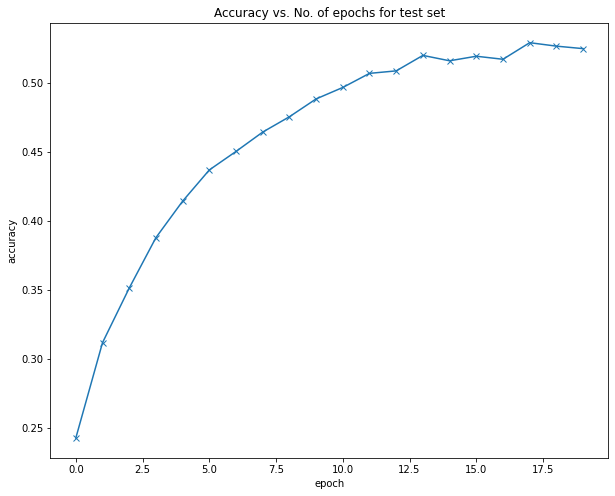

Accuracy after 20 epochs: 0.5246
Loss after 20 epochs: 0.02135171517133713


In [19]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=512, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=20, learning_rate=0.005, momentum=0.2)

### Train and predict for learning_rate=0.001 & momentum=0.5 for 20 epochs

Training for learning rate: 0.005, momentum: 0.5



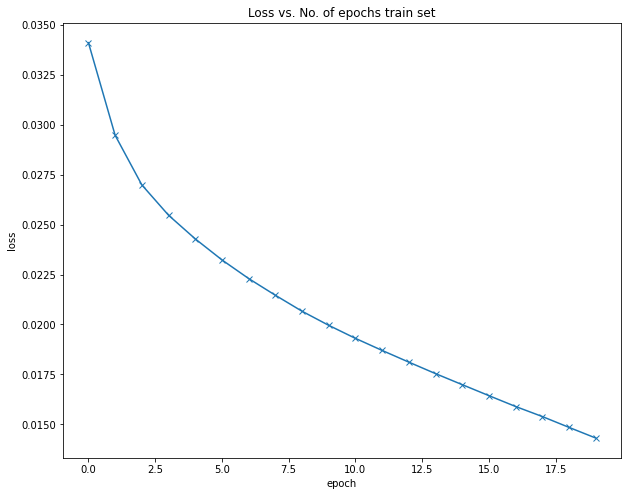

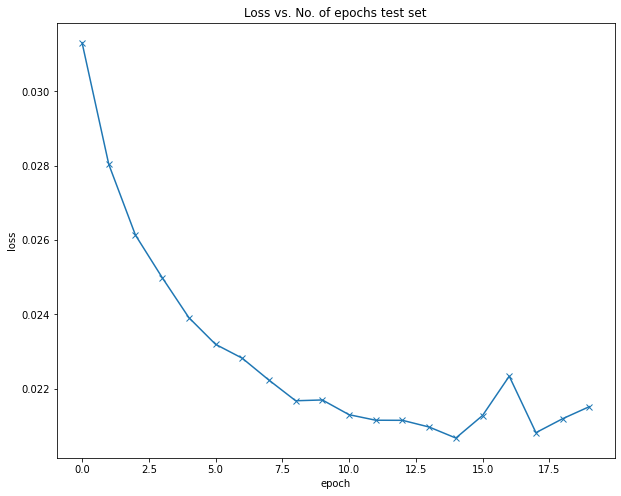

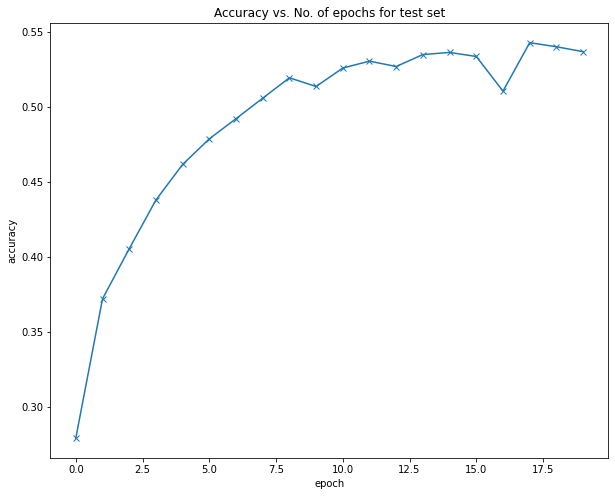

Accuracy after 20 epochs: 0.5366
Loss after 20 epochs: 0.021512289917469025


In [21]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=512, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=20, learning_rate=0.005, momentum=0.5)

## Using different NN architectures.

### Training Neural Network 3 * 32 * 32 -> 512 -> 512 -> 10, 10 neurons, learning_rate=0.005, momentum=0.9 for 10 epochs.

Training for learning rate: 0.005, momentum: 0.9



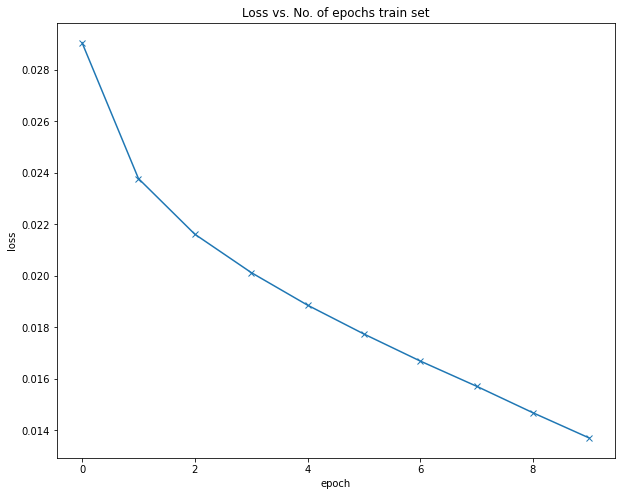

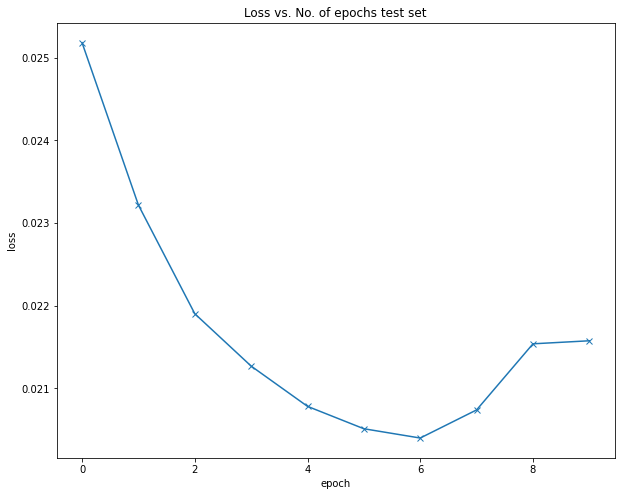

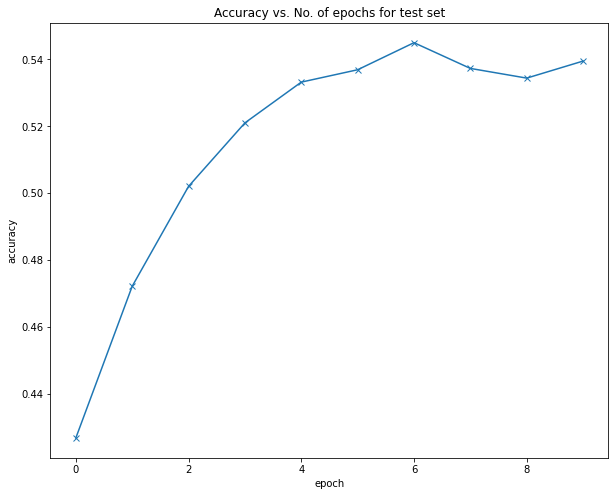

Accuracy after 10 epochs: 0.5395
Loss after 10 epochs: 0.02157501176595688


In [23]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=512, third_layer=512, out_layer=10).to(device)
train_nn(model, num_epochs=10, learning_rate=0.005, momentum=0.9)

### Training Neural Network 3 * 32 * 32 -> 256 -> 256 -> 10, learning_rate=0.005, momentum=0.9 for 10 epochs

Training for learning rate: 0.005, momentum: 0.9



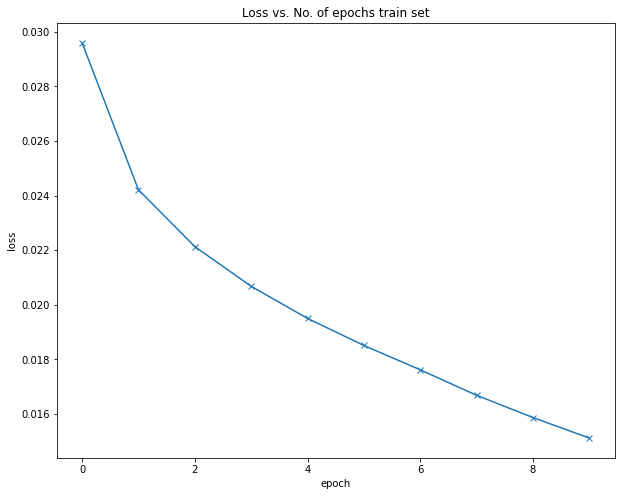

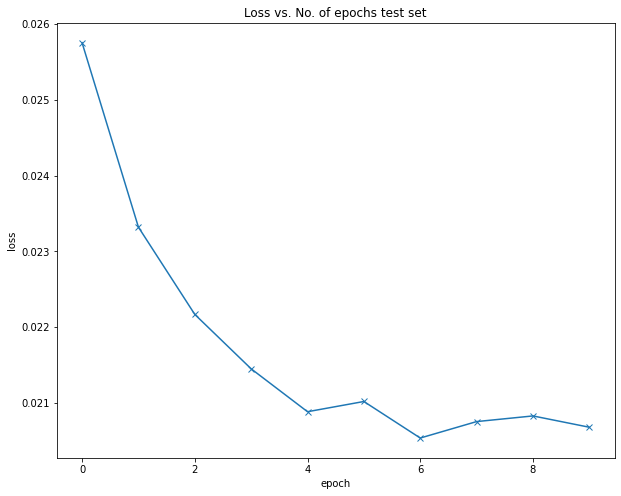

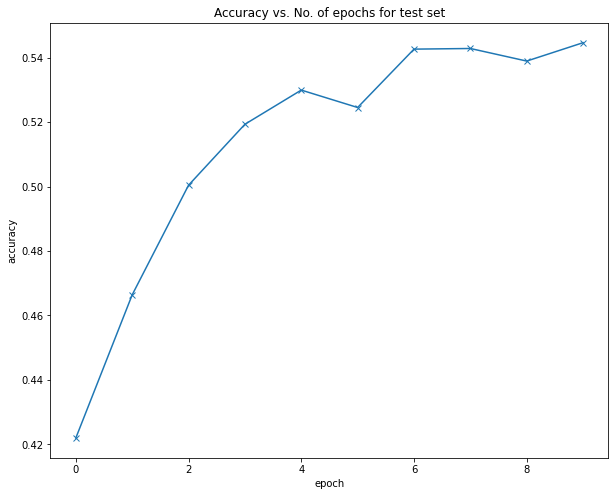

Accuracy after 10 epochs: 0.5446
Loss after 10 epochs: 0.02067743127346039


In [24]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=256, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=10, learning_rate=0.005, momentum=0.9)

## Conclusion

So far the best and also the cheapest model seems to be 3 * 32 * 32 -> 256 -> 256 -> 10 with learning_rate=0.005 & momentum=0.9 for 10 epochs. Let's extract the structure of this model.

### Model Structure

In [25]:
print(model)

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)
Layer: linear_relu_stack.0.weight | Size: torch.Size([256, 3072]) | Values : tensor([[ 0.0034, -0.0005,  0.0016,  ...,  0.0148,  0.0196,  0.0311],
        [ 0.0096,  0.0269,  0.0085,  ..., -0.0147,  0.0132,  0.0015]],
       device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([256]) | Values : tensor([0.0033, 0.0468], device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([256, 256]) | Values : tensor([[ 0.0260,  0.0040,  0.0005,  0.0088, -0.0646,  0.0013, -0.0138, -0.0425,
         -0.0484,  0.0745,  0.0044,  0